In [1]:
# 忽略warnings
import warnings 
warnings.filterwarnings('ignore') 

# 导入Python通用库
import matplotlib.pyplot as plt
import numpy as np
import os

# 强制使用CPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# 导入TF 2.0并设置GPU
import tensorflow as tf
# 导入Keras库
from tensorflow import keras
# 设置使用GPU显存的比例
# from keras.backend.tensorflow_backend import set_session
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.6
# tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config)) 
# 导入util模块的各种方法
# from keras.utils.np_utils import to_categorical
# 导入数据集
from keras.datasets import imdb
# 导入模型、优化器、损失函数等等
from keras import preprocessing
from keras import regularizers
from keras import optimizers
from keras import metrics
from keras import models
from keras import losses
from keras import layers
# 导入Keras字符处理模块
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, GRU
from keras.preprocessing import sequence
from keras.models import Sequential

Using TensorFlow backend.


# 06. 深度学习用于文本和序列
本章将介绍使用深度学习模型处理文本、时间序列和一般的序列数据。用于处理序列的两种基本的深度学习算法分别是`循环神经网络`（recurrent neural network）和`一维卷积神经网络`（1D convnet），后者是上一章介绍的二维卷积神经网络的一维版本。本章将讨论这两种方法。

这些算法的应用包括：
+ 文档分类和时间序列分类，比如识别文章的主题或书的作者
+ 时间序列对比，比如估测两个文档或两支股票行情的相关程度
+ 序列到序列的学习，比如将英语翻译成法语
+ 情感分析，比如将推文或电影评论的情感划分为正面或负面
+ 时间序列预测，比如根据某地最近的天气数据来预测未来天气

## 6.2 理解循环神经网络
目前你见过的所有神经网络（比如密集连接网络和卷积神经网络）都有一个主要特点，那就是它们都没有记忆。它们单独处理每个输入，在输入与输入之间没有保存任何状态。对于这样的网络，要想处理数据点的序列或时间序列，你需要向网络同时展示整个序列，即将序列转换成单个数据点。例如，你在`IMDB`示例中就是这么做的：将全部电影评论转换为一个大向量，然后一次性处理。这种网络叫作`前馈网络`（feedforward network）。

与此相反，当你在阅读这个句子时，你是一个词一个词地阅读，同时会记住之前的内容。这让你能够动态理解这个句子所传达的含义。生物智能以渐进的方式处理信息，同时保存一个关于所处理内容的内部模型，这个模型是根据过去的信息构建的，并随着新信息的进入而不断更新。

`循环神经网络`（RNN，recurrent neural network）采用同样的原理，不过是一个极其简化的版本：它处理序列的方式是，遍历所有序列元素，并保存一个`状态`（state），其中包含与已查看内容相关的信息。实际上，RNN是一类具有内部环的神经网络（见`图6-9`）。在处理两个不同的独立序列（比如两条不同的`IMDB`评论）之间，RNN状态会被重置，因此，你仍可以将一个序列看作单个数据点，即网络的单个输入。真正改变的是，数据点不再是在单个步骤中进行处理，相反，网络内部会对序列元素进行遍历。

<img src="images/06_09.png" style="width:300px;"/>

为了将`环`（loop）和`状态`（state）的概念解释清楚，我们用`Numpy`来实现一个简单`RNN`的前向传递。这个`RNN`的输入是一个张量序列，我们将其编码成大小为`(timesteps, input_features)`的二维张量。它对`时间步`（timestep）进行遍历，在每个时间步，它考虑`t`时刻的当前状态与`t`时刻的输入【形状为`(input_features,)`】，对二者计算得到`t`时刻的输出。然后，我们将下一个时间步的状态设置为上一个时间步的输出。对于第一个时间步，上一个时间步的输出没有定义，所以它没有当前状态。因此，你需要将状态初始化为一个全零向量，这叫作网络的`初始状态`（initial state）。

`RNN`的伪代码如下所示：

```python
# t时刻的状态
state_t = 0
# 对序列元素进行遍历
for input_t in input_sequence: 
    output_t = f(input_t, state_t)
    # 前一次的输出变成下一次迭代的状态
    state_t = output_t 
```

你甚至可以给出具体的函数$f$：从输入和状态到输出的变换，其参数包括两个矩阵（$W$和$U$）和一个偏置向量。它类似于前馈网络中密集连接层所做的变换：
```python
state_t = 0
for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t
```

为了将这些概念的含义解释得更加清楚，我们为简单`RNN`的前向传播编写一个简单的`Numpy`实现。

In [2]:
# 输入序列的时间步数
timesteps = 100
# 输入特征空间的维度
input_features = 32 
# 输出特征空间的维度
output_features = 64 
# 输入数据：随机噪声，仅作为示例
inputs = np.random.random((timesteps, input_features))
# 初始状态：全零向量
state_t = np.zeros((output_features,)) 
# （以下3行）创建随机的权重矩阵
W = np.random.random((output_features, input_features)) 
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))                   
# 保存结果
successive_outputs = []
# input_t是形状为(input_features,)的向量
for input_t in inputs: 
    # 由输入和当前状态（前一个输出）计算得到当前输出
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b) 
    # 将这个输出保存到一个列表中
    successive_outputs.append(output_t)  
    # 更新网络的状态，用于下一个时间步
    state_t = output_t 
# 最终输出是一个形状为(timesteps, output_features)的二维张量
final_output_sequence = np.stack(successive_outputs, axis=0)

足够简单。总之，`RNN`是一个 for 循环，它重复使用循环前一次迭代的计算结果，仅此而已。当然，你可以构建许多不同的`RNN`，它们都满足上述定义。这个例子只是最简单的`RNN`表述之一。`RNN`的特征在于其时间步函数，比如前面例子中的这个函数（见`图6-10`）。

<img src="images/06_10.png" style="width:600px;"/>

> **注意**　
> 本例中，最终输出是一个形状为`(timesteps, output_features)`的二维张量，其中每个时间步是循环在`t`时刻的输出。输出张量中的每个时间步`t`包含输入序列中时间步`0~t`的信息，即关于全部过去的信息。因此，在多数情况下，你并不需要这个所有输出组成的序列，你只需要最后一个输出（循环结束时的`output_t`），因为它已经包含了整个序列的信息

### 6.2.1 Keras 中的循环层
上面`Numpy`的简单实现，对应一个实际的`Keras`层，即`SimpleRNN`层。

二者有一点小小的区别：`SimpleRNN`层能够像其他`Keras`层一样处理序列批量，而不是像`Numpy`示例那样只能处理单个序列。因此，它接收形状为`(batch_size, timesteps, input_features)`的输入，而不是`(timesteps, input_features)`。

与`Keras`中的所有循环层一样，`SimpleRNN`可以在两种不同的模式下运行：一种是返回每个时间步连续输出的完整序列，即形状为`(batch_size, timesteps, output_features)`的三维张量；另一种是只返回每个输入序列的最终输出，即形状为`(batch_size, output_features)`的二维张量。这两种模式由`return_sequences`这个构造函数参数来控制。

我们来看一个使用`SimpleRNN`的例子，它只返回最后一个时间步的输出。

In [3]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


下面这个例子返回完整的状态序列。

In [4]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


为了提高网络的表示能力，将多个循环层逐个堆叠有时也是很有用的。在这种情况下，你需要让所有中间层都返回完整的输出序列。

In [5]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
# 最后一层仅返回最终输出
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


接下来，我们将这个模型应用于`IMDB`电影评论分类问题。首先，对数据进行预处理。

In [6]:
# 作为特征的单词个数
max_features = 10000
# 在这么多单词之后截断文本（这些单词都属于前max_features个最常见的单词）
maxlen = 500
batch_size = 32

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


我们用一个`Embedding`层和一个`SimpleRNN`层来训练一个简单的循环网络。

In [7]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 14s 682us/step - loss: 0.5720 - acc: 0.6955 - val_loss: 0.4138 - val_acc: 0.8260
Epoch 2/10
20000/20000 [==============================] - 13s 673us/step - loss: 0.3630 - acc: 0.8493 - val_loss: 0.6094 - val_acc: 0.7356
Epoch 3/10
20000/20000 [==============================] - 14s 685us/step - loss: 0.2868 - acc: 0.8879 - val_loss: 0.3591 - val_acc: 0.8462
Epoch 4/10
20000/20000 [==============================] - 15s 751us/step - loss: 0.2239 - acc: 0.9151 - val_loss: 0.4124 - val_acc: 0.8558
Epoch 5/10
20000/20000 [==============================] - 15s 749us/step - loss: 0.1759 - acc: 0.9367 - val_loss: 0.4013 - val_acc: 0.8370
Epoch 6/10
20000/20000 [==============================] - 15s 748us/step - loss: 0.1534 - acc: 0.9485 - val_loss: 0.3962 - val_acc: 0.8616
Epoch 7/10
20000/20000 [==============================] - 15s 748us/step - loss: 0.0994 - acc: 0.9656 - val_loss: 0.5

接下来显示训练和验证的损失和精度：

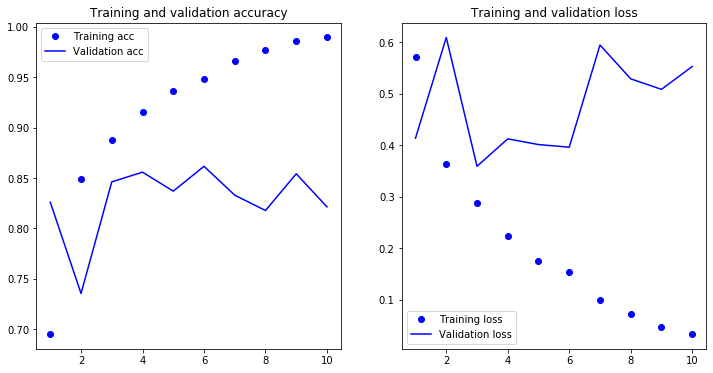

In [8]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

提醒一下，在第3章，处理这个数据集的第一个简单方法得到的测试精度是`88%`。不幸的是，与这个基准相比，这个小型循环网络的表现并不好（验证精度只有`85%`）。问题的部分原因在于，输入只考虑了前500个单词，而不是整个序列，因此，RNN获得的信息比前面的基准模型更少。另一部分原因在于，SimpleRNN 不擅长处理长序列，比如文本。

其他类型的循环层的表现要好得多。我们来看几个更高级的循环层。

### 6.2.2 理解 LSTM 层和 GRU 层
`SimpleRNN`并不是`Keras`中唯一可用的循环层，还有另外两个：`LSTM`和`GRU`。在实践中总会用到其中之一，因为`SimpleRNN`通常过于简化，没有实用价值。`SimpleRNN`的最大问题是，在时刻`t`，理论上来说，它应该能够记住许多时间步之前见过的信息，但实际上它是不可能学到这种长期依赖的。其原因在于`梯度消失问题`（vanishing gradient problem），这一效应类似于在层数较多的非循环网络（即前馈网络）中观察到的效应：随着层数的增加，网络最终变得无法训练。Hochreiter、Schmidhuber和Bengio在20世纪90年代初研究了这一效应的理论原因。`LSTM`层和`GRU`层都是为了解决这个问题而设计的。

先来看`LSTM`层。其背后的`长短期记忆`（LSTM，long short-term memory）算法由Hochreiter和Schmidhuber在1997年开发，是二人研究梯度消失问题的重要成果。

`LSTM`层是`SimpleRNN`层的一种变体，它增加了一种携带信息跨越多个时间步的方法。假设有一条传送带，其运行方向平行于你所处理的序列。序列中的信息可以在任意位置跳上传送带，然后被传送到更晚的时间步，并在需要时原封不动地跳回来。这实际上就是`LSTM`的原理：它保存信息以便后面使用，从而防止较早期的信号在处理过程中逐渐消失。

为了详细了解`LSTM`，我们先从`SimpleRNN`单元开始讲起（见`图6-13`）。因为有许多个权重矩阵，所以对单元中的$W$和$U$两个矩阵添加下标字母$o$（$Wo$和$Uo$），表示输出。

<img src="images/06_13.png" style="width:590px;"/>

我们向这张图像中添加额外的数据流，其中携带着跨越时间步的信息。它在不同的时间步的值叫作$Ct$，其中$C$表示`携带`（carry）。这些信息将会对单元产生以下影响：它将与输入连接和循环连接进行运算（通过一个密集变换，即与权重矩阵作点积，然后加上一个偏置，再应用一个激活函数），从而影响传递到下一个时间步的状态（通过一个激活函数和一个乘法运算）。从概念上来看，携带数据流是一种调节下一个输出和下一个状态的方法（见图 6-14）。到目前为止都很简单。

<img src="images/06_14.png" style="width:600px;"/>

下面来看这一方法的精妙之处，即携带数据流下一个值的计算方法。它涉及三个不同的变换，这三个变换的形式都和 SimpleRNN 单元相同：
```python
y = activation(dot(state_t, U) + dot(input_t, W) + b)
```

但这三个变换都具有各自的权重矩阵，我们分别用字母$i$、$f$和$k$作为下标。目前的模型架构如下所示：
```python
output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(C_t, Vo) + bo)

i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)
```

对$i\_t$、$f\_t$和$k\_t$进行组合，可以得到新的携带状态（下一个$c\_t$）：
```python
c_t+1 = i_t * k_t + c_t * f_t
```

`图6-15`给出了添加上述架构之后的图示：

<img src="images/06_15.png" style="width:600px;"/>

如果要更哲学一点，你还可以解释每个运算的目的。比如你可以说，将$c\_t$和$f\_t$相乘，是为了故意遗忘携带数据流中的不相关信息。同时，$i\_t$和$k\_t$都提供关于当前的信息，可以用新信息来更新携带轨道。但归根结底，这些解释并没有多大意义，因为这些运算的实际效果是由参数化权重决定的，而权重是以端到端的方式进行学习，每次训练都要从头开始，不可能为某个运算赋予特定的目的。`RNN`单元的类型（如前所述）决定了你的假设空间，即在训练期间搜索良好模型配置的空间，但它不能决定`RNN`单元的作用，那是由单元权重来决定的。同一个单元具有不同的权重，可以实现完全不同的作用。因此，组成`RNN`单元的运算组合，最好被解释为对搜索的一组约束，而不是一种工程意义上的设计。

对于研究人员来说，这种约束的选择（即如何实现`RNN`单元）似乎最好是留给最优化算法来完成（比如遗传算法或强化学习过程），而不是让人类工程师来完成。在未来，那将是我们构建网络的方式。总之，你不需要理解关于`LSTM`单元具体架构的任何内容。作为人类，理解它不应该是你要做的。你只需要记住`LSTM`单元的作用：允许过去的信息稍后重新进入，从而解决梯度消失问题。

### 6.2.3 Keras中一个LSTM的具体例子
现在我们来看一个更实际的问题：使用`LSTM`层来创建一个模型，然后在`IMDB`数据上训练模型。这个网络与前面介绍的`SimpleRNN`网络类似。你只需指定`LSTM`层的输出维度，其他所有参数（有很多）都使用`Keras`默认值。`Keras`具有很好的默认值，无须手动调参，模型通常也能正常运行。

In [9]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 33s 2ms/step - loss: 0.5085 - acc: 0.7635 - val_loss: 0.4048 - val_acc: 0.8248
Epoch 2/10
20000/20000 [==============================] - 33s 2ms/step - loss: 0.2965 - acc: 0.8844 - val_loss: 0.3021 - val_acc: 0.8770
Epoch 3/10
20000/20000 [==============================] - 33s 2ms/step - loss: 0.2328 - acc: 0.9106 - val_loss: 0.4033 - val_acc: 0.8352
Epoch 4/10
20000/20000 [==============================] - 33s 2ms/step - loss: 0.2000 - acc: 0.9266 - val_loss: 0.3641 - val_acc: 0.8396
Epoch 5/10
20000/20000 [==============================] - 32s 2ms/step - loss: 0.1744 - acc: 0.9376 - val_loss: 0.3078 - val_acc: 0.8708
Epoch 6/10
20000/20000 [==============================] - 33s 2ms/step - loss: 0.1574 - acc: 0.9443 - val_loss: 0.3641 - val_acc: 0.8776
Epoch 7/10
20000/20000 [==============================] - 33s 2ms/step - loss: 0.1393 - acc: 0.9498 - val_loss: 0.3956 - val_acc:

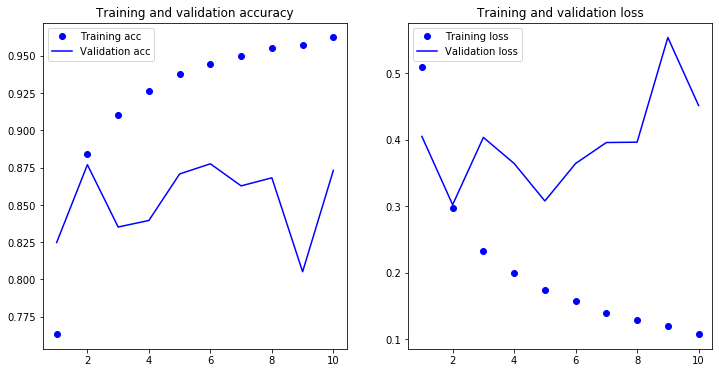

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

这一次，验证精度达到了`89%`。还不错，肯定比`SimpleRNN`网络好多了，这主要是因为`LSTM`受梯度消失问题的影响要小得多。这个结果也比第3章的全连接网络略好，虽然使用的数据量比第3章要少。此处在500个时间步之后将序列截断，而在第3章是读取整个序列。

但对于一种计算量如此之大的方法而言，这个结果也说不上是突破性的。为什么`LSTM`不能表现得更好？一个原因是你没有花力气来调节超参数，比如嵌入维度或`LSTM`输出维度。另一个原因可能是缺少正则化。但说实话，主要原因在于，适用于评论分析全局的长期性结构（这正是`LSTM`所擅长的），对情感分析问题帮助不大。对于这样的基本问题，观察每条评论中出现了哪些词及其出现频率就可以很好地解决。这也正是第一个全连接方法的做法。但还有更加困难的自然语言处理问题，特别是问答和机器翻译，这时 LSTM 的优势就明显了。

### 6.2.4 小结
现在你已经学会了以下内容：
+ `RNN`的概念及其工作原理
+ `LSTM`是什么，为什么它在长序列上的效果要好于普通`RNN`
+ 如何使用`Keras`的`RNN`层来处理序列数据

接下来，我们将介绍`RNN`几个更高级的功能，这可以帮你有效利用深度学习序列模型。